<a href="https://colab.research.google.com/github/leeCodingStudio/Python_machine_learning/blob/master/19_%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 에일리언 vs 프레데터 데이터셋
* https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images
* 캐글 로그인 -> 계정 클릭 -> Your Profile -> Account -> API 항목에 Create New API Token -> json을 다운로드
* {"username":"lehj2308","key":"d9b15d6ab53e91e3ed810d190ebc937e"}

In [ ]:
import os

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'lehj2308'                      # username
os.environ['KAGGLE_KEY'] = 'd9b15d6ab53e91e3ed810d190ebc937e'   # key

In [ ]:
!kaggle datasets download -d pmigdal/alien-vs-predator-images
!unzip -q alien-vs-predator-images.zip

 85% 12.0M/14.1M [00:01<00:00, 11.1MB/s]
100% 14.1M/14.1M [00:01<00:00, 8.64MB/s]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 2. 이미지 증강 기법(Image Agumentation)
* 원본 이미지(데이터)를 조작하여 원본과는 크고 작은 변화를 가진 이미지를 생성
    * 일반적으로 모델 성능이 좋아짐
    * Over fiting 방지
* https://pytorch.org/vision/master/transforms.html

In [ ]:
data_transforms = {
    'train': transforms.Compose([   # Compose(): 여러개의 함수를 한번에 적용
        transforms.Resize((224, 224)), # 이미지 크기 조절
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                # 이미지의 기울기를 랜덤으로 변환한다. shear: 최대 기울기, scale: 이미지 크기 범위
                                # 하나의 이미지로 여러번 학습 시키기 위해 기울기를 랜덤으로 바꿔준다.
        transforms.RandomHorizontalFlip(), # 이미지 반전
        transforms.ToTensor(), # 이미지를 텐서로 변경
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [ ]:
def target_transforms(target):
    return torch.FloatTensor([target])

In [ ]:
image_datasets = {
    'train': datasets.ImageFolder('data/train', data_transforms['train'], target_transform=target_transforms),
    'validation': datasets.ImageFolder('data/validation', data_transforms['validation'], target_transform=target_transforms)
}

dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation':DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

print(len(image_datasets['train']), len(image_datasets['validation']))

694 200


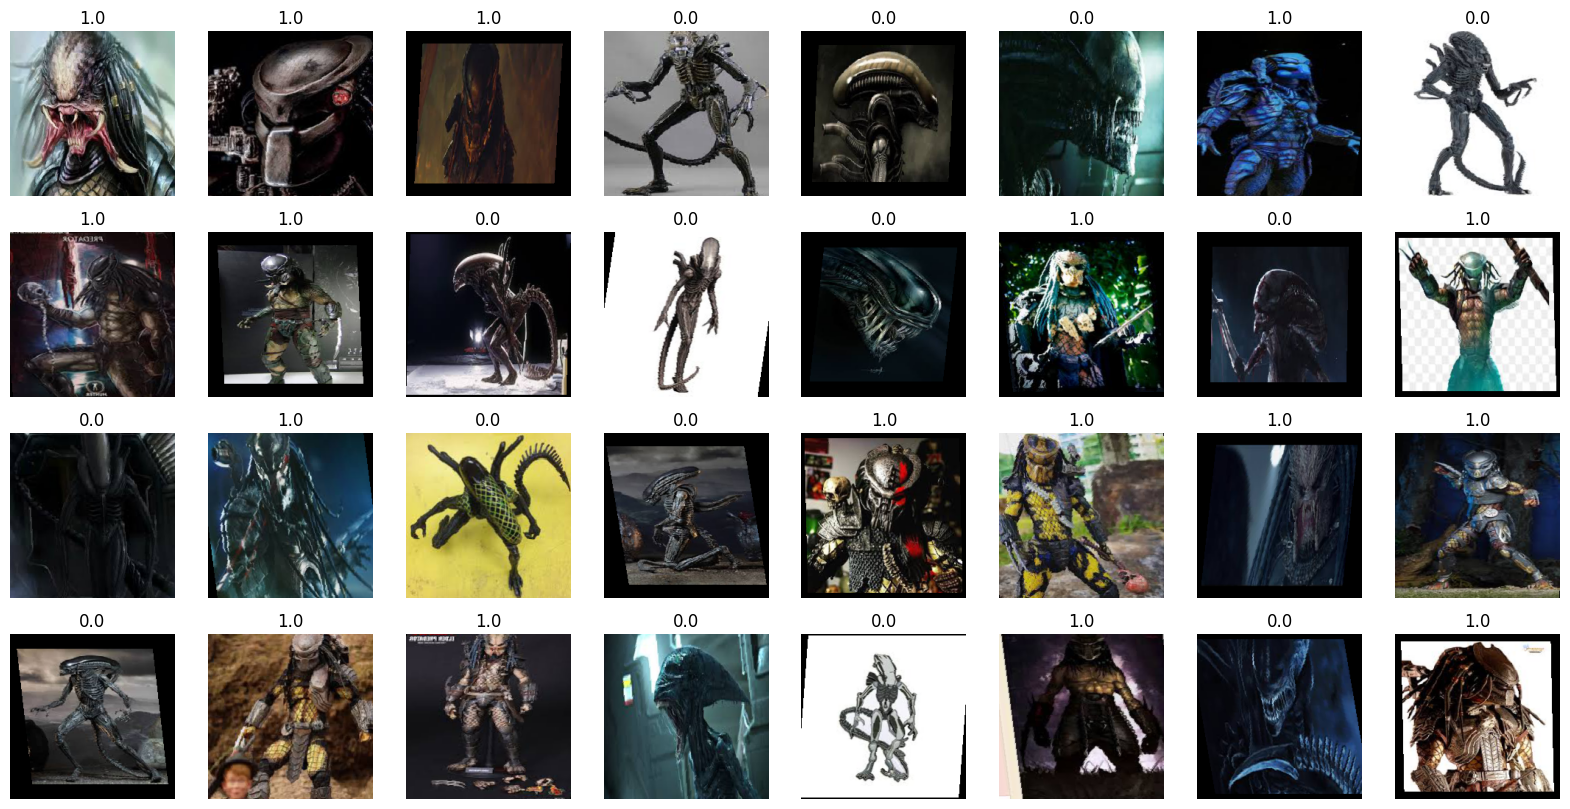

In [ ]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for img, label, ax in zip(imgs, labels, axes.flatten()):
    ax.set_title(label.item())
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')

# 3. 전이 학습(Transfer Learning)
* 하나의 작업을 위해 훈련된 모델을 유사 작업 수행 모델의 시작점으로 활용하는 딥러닝 접근법
* 신경망은 처음부터 새로 학습하는 것 보다 전이 학습을 통해 업데이트하고 재학습하는 편이 더 빠르고 간편함
* 전이 학습은 여러 응용 분야 중에서도 특히 검출, 영상 인식, 음성 인식, 검색 분야에 많이 사용

![](https://miro.medium.com/max/1400/1*9GTEzcO8KxxrfutmtsPs3Q.png)

### 3-1. 전이 학습의 고려할 점
* 크기: 모델 크기의 중요성은 모델을 배포할 위치와 방법에 따라 달라짐
* 정확도: 재훈련 전의 모델 성능은 어느 정도인지 확인이 필요
* 예측 속도: 하드웨어 및 배치 크기와 같은 다른 딥러닝 요소는 물론 선택된 모델의 아키텍쳐와 모델 크기에 따라서도 달라짐

![](https://kr.mathworks.com/discovery/transfer-learning/_jcr_content/mainParsys/image.adapt.full.medium.jpg/1634621302937.jpg)

# 4. 사전 학습된 ResNet50 모델
* [파이토치에서 제공하는 사전학습 모델들](https://pytorch.org/vision/stable/models.html)

![](https://i.stack.imgur.com/gI4zT.png)

### 4-1. 이미지넷(ImageNet)
* 이미지 데이터베이스
* 1000개의 동물과 사물 이미지를 포함

![](https://i.imgur.com/5Rz5s8e.png)

In [ ]:
# model = models.resnet50(pretrained=True).to(device)
model = models.resnet50(weights='IMAGENET1K_V1').to(device) # 미리
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 297MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 4-2. Freeze Layers
* 특징을 뽑아내는 CNN의 앞쪽 컴볼루션 레이어들은 학습을 하지 않도록 설정
* 출력 부분의 레이어(fc)를 다시 설정하여 분류에 맞게 설정

In [ ]:
for param in model.parameters():
    param.requires_grad = False # 가져온 파라미터(W, b)를 업데이트하지 않음

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# 학습: fc 부분만 학습하므로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)

            loss = nn.BCELoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss.item()

            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc.item()

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])

        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10, Loss: 0.6575, Accuracy: 67.94%
validation: Epoch    1/10, Loss: 0.5680, Accuracy: 83.04%
train     : Epoch    2/10, Loss: 0.4635, Accuracy: 85.24%
validation: Epoch    2/10, Loss: 0.3693, Accuracy: 90.18%
train     : Epoch    3/10, Loss: 0.3225, Accuracy: 90.86%
validation: Epoch    3/10, Loss: 0.3127, Accuracy: 90.62%
train     : Epoch    4/10, Loss: 0.2657, Accuracy: 89.64%
validation: Epoch    4/10, Loss: 0.2452, Accuracy: 91.52%
train     : Epoch    5/10, Loss: 0.2357, Accuracy: 91.84%
validation: Epoch    5/10, Loss: 0.2446, Accuracy: 90.18%
train     : Epoch    6/10, Loss: 0.1988, Accuracy: 91.90%
validation: Epoch    6/10, Loss: 0.2406, Accuracy: 90.18%
train     : Epoch    7/10, Loss: 0.1941, Accuracy: 92.69%
validation: Epoch    7/10, Loss: 0.2142, Accuracy: 91.07%
train     : Epoch    8/10, Loss: 0.1852, Accuracy: 92.36%
validation: Epoch    8/10, Loss: 0.2113, Accuracy: 91.07%
train     : Epoch    9/10, Loss: 0.1663, Accuracy: 93.40%
validation: Ep

In [ ]:
torch.save(model.state_dict(), 'model.h5')

In [ ]:
model = models.resnet50().to(device)

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

In [ ]:
# 학습: fc 부분만 학습하므로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)

            loss = nn.BCELoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss.item()

            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc.item()

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])

        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10, Loss: 0.7881, Accuracy: 48.30%
validation: Epoch    1/10, Loss: 0.6978, Accuracy: 44.64%
train     : Epoch    2/10, Loss: 0.7050, Accuracy: 50.37%
validation: Epoch    2/10, Loss: 0.6881, Accuracy: 55.36%
train     : Epoch    3/10, Loss: 0.6939, Accuracy: 50.40%
validation: Epoch    3/10, Loss: 0.7146, Accuracy: 44.64%
train     : Epoch    4/10, Loss: 0.7019, Accuracy: 52.52%
validation: Epoch    4/10, Loss: 0.7051, Accuracy: 44.64%
train     : Epoch    5/10, Loss: 0.6975, Accuracy: 52.07%
validation: Epoch    5/10, Loss: 0.7079, Accuracy: 44.64%
train     : Epoch    6/10, Loss: 0.6983, Accuracy: 51.37%
validation: Epoch    6/10, Loss: 0.6780, Accuracy: 60.27%
train     : Epoch    7/10, Loss: 0.6815, Accuracy: 54.11%
validation: Epoch    7/10, Loss: 0.6979, Accuracy: 51.34%
train     : Epoch    8/10, Loss: 0.6964, Accuracy: 50.85%
validation: Epoch    8/10, Loss: 0.6807, Accuracy: 55.80%
train     : Epoch    9/10, Loss: 0.6813, Accuracy: 55.94%
validation: Ep

In [ ]:
# 모델 로드
model.load_state_dict(torch.load('model.h5'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# 학습: fc 부분만 학습하므로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)

            loss = nn.BCELoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss.item()

            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc.item()

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])

        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10, Loss: 0.1778, Accuracy: 93.70%
validation: Epoch    1/10, Loss: 0.1951, Accuracy: 91.52%
train     : Epoch    2/10, Loss: 0.1324, Accuracy: 95.61%
validation: Epoch    2/10, Loss: 0.2117, Accuracy: 91.52%
train     : Epoch    3/10, Loss: 0.1676, Accuracy: 93.89%
validation: Epoch    3/10, Loss: 0.2524, Accuracy: 89.29%
train     : Epoch    4/10, Loss: 0.1874, Accuracy: 92.76%
validation: Epoch    4/10, Loss: 0.2056, Accuracy: 91.96%
train     : Epoch    5/10, Loss: 0.1575, Accuracy: 94.60%
validation: Epoch    5/10, Loss: 0.1873, Accuracy: 91.52%
train     : Epoch    6/10, Loss: 0.1322, Accuracy: 94.98%
validation: Epoch    6/10, Loss: 0.1838, Accuracy: 92.41%
train     : Epoch    7/10, Loss: 0.1432, Accuracy: 94.19%
validation: Epoch    7/10, Loss: 0.1870, Accuracy: 93.75%
train     : Epoch    8/10, Loss: 0.1640, Accuracy: 94.03%
validation: Epoch    8/10, Loss: 0.1811, Accuracy: 91.52%
train     : Epoch    9/10, Loss: 0.1435, Accuracy: 94.41%
validation: Ep

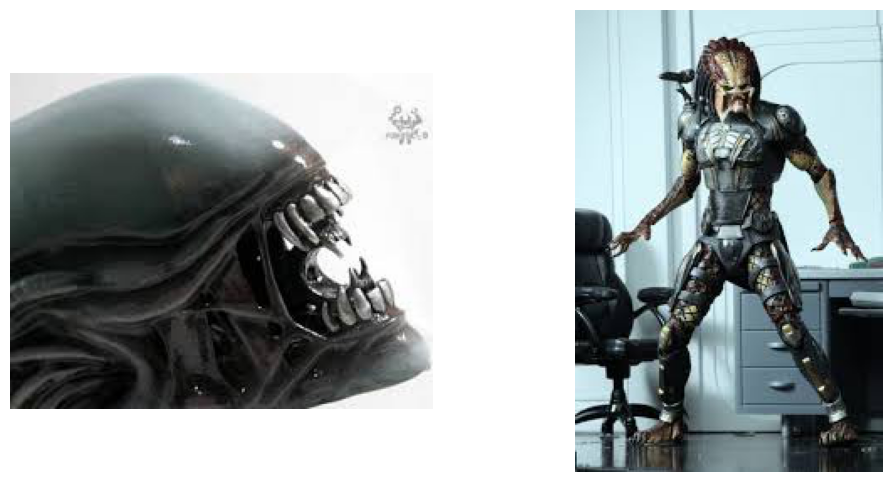

In [ ]:
# 테스트
from PIL import Image

img1 = Image.open('data/validation/alien/32.jpg')
img2 = Image.open('data/validation/predator/45.jpg')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [ ]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [ ]:
test_batch = torch.stack([img1_input, img2_input]) # 두 개를 붙임
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [ ]:
y_pred = model(test_batch)
y_pred

tensor([[0.6319],
        [0.9820]], device='cuda:0', grad_fn=<SigmoidBackward0>)

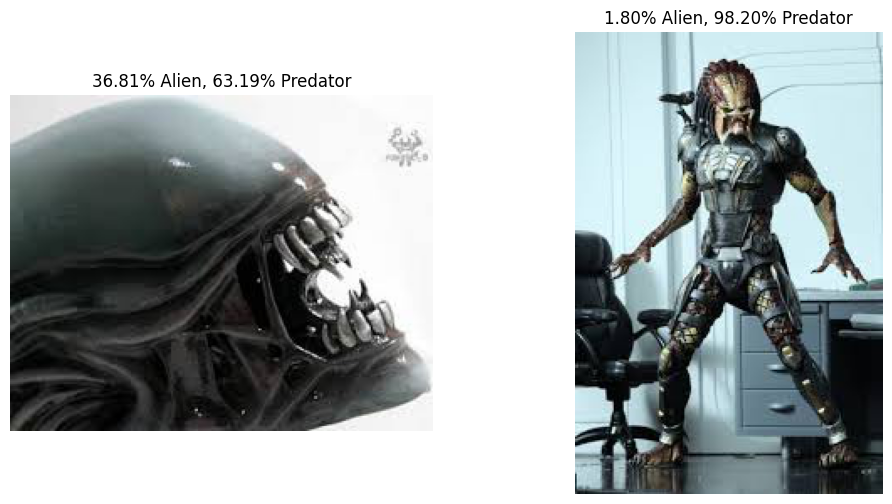

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title(f'{(1-y_pred[0, 0]) * 100:.2f}% Alien, {y_pred[0, 0] * 100:.2f}% Predator')
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title(f'{(1-y_pred[1, 0]) * 100:.2f}% Alien, {y_pred[1, 0] * 100:.2f}% Predator')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

### 과제
* 전이 학습으로 강아지와 고양이 구분하기
* https://www.kaggle.com/c/dogs-vs-cats